In [1]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

import torch
import pandas as pd
from transformers import BertTokenizer, BertModel,BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from gensim.models import Word2Vec

%pip install Sastrawi
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

label_type = ['NotPromotion', 'Promotion']

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
training_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/train.csv', sep=',').dropna()
testing_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/test.csv', sep=',').dropna()
validation_data = pd.read_csv('/kaggle/input/dataset-scraping-sendiri/val.csv').dropna()

# combined_data = combined_data.sample(frac = 1)
training_data.head()
print(training_data.info(), end="\n=====================================\n")
print(testing_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2736 entries, 0 to 2735
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2736 non-null   object
 1   label   2736 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 42.9+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 342 entries, 0 to 341
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    342 non-null    object
 1   label   342 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 5.5+ KB
None


In [3]:
texts_raw_train = training_data['text'].values.copy()
texts_raw_test = testing_data['text'].values.copy()
texts_raw_val = validation_data['text'].values.copy()
y_train = training_data['label'].values.copy()
y_test = testing_data['label'].values.copy()
y_val = validation_data['label'].values.copy()

In [4]:
stop_factory = StopWordRemoverFactory()
stopwords = stop_factory.get_stop_words()
custom_stopwords = ['aku', 'yg', 'kamu']
stopwords += custom_stopwords

pattern = r"[^A-Za-z ]"

# lemmatizer = WordNetLemmatizer()

def preprocess_text(texts):
    for index, text in enumerate(texts):
        # text = text.lower()

        # text = re.sub(pattern, '', text)

        word_list = word_tokenize(text)
        word_list = [word for word in word_list if word not in stopwords]

        # word_list = [lemmatizer.lemmatize(word) for word in word_list]

        text = ' '.join(word_list)
        texts[index] = text
    return texts

In [5]:
texts_train = preprocess_text(texts_raw_train)
texts_test = preprocess_text(texts_raw_test)
texts_val = preprocess_text(texts_raw_val)
print(texts_train)

['Mencari pengalaman daring lancar ? AERO88 mungkin solusinya .'
 'Itu kayanya kasih tanda deh lewatin apa ngga , contohnya kerucut+tong sampah biru'
 'Whatsapp Telegram Livechat Daftar Login Hdtoto Beranda Slot Online Live Casino Sportsbook Arcade Togel Poker slider Jackpot Daily Wins Gates of Olympus Bonanza Gold < Starlight Princess Sweet power thor megaways Treasure Wild Aztec Gems Gatot Kaca Popular Games bowl Mahjong Ways Break Away Lucky Wilds Koi Gate 1000 Wishes Gem Saviour Conquest Chronicles X Up Gold Blitz Elven Roma Silverback Multiplier Mountain Fiery Sevens Hot Phoenix Rises Neko Fortune Tiger garuda Treasures Bandito fireworks Dreams Macau Rooster Rumble > Platform Hiburan Terbaru No.1 Indonesia Penyedia pragmatic pgsoft habanero cq9 spadegaming ttg joker microgaming ion sexy gaming allbet idnlive saba sports Metode Pembayaran Transfer Bank Pulsa E-Money ©2024 Hdtoto . All rights reserved | 18+'
 ... 'Kerennn'
 'Saya merekomendasikan ρułau777 siapa mencari tempat terper

In [6]:
X_train = texts_train
X_test = texts_test
X_val = texts_val
y_train = training_data['label'].values
y_test = testing_data['label'].values
y_val = validation_data['label'].values

In [7]:
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch

# Load BERT tokenizer and model
model_name = 'indobenchmark/indobert-base-p2'  # You can choose other variants
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Move model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def vectorize_texts(texts, tokenizer, model, max_length=512):
    vectors = []
    
    for text in texts:
        # Tokenize text
        inputs = tokenizer(
            text,
            padding=True,
            truncation=True,
            max_length=max_length,
            return_tensors='pt'
        ).to(device)  # Move inputs to GPU
        
        # Get BERT embeddings
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Use last hidden states (batch_size, sequence_length, hidden_size)
        last_hidden_states = outputs.last_hidden_state
        
        # Remove batch dimension and convert to numpy
        embeddings = last_hidden_states.squeeze(0).cpu().numpy()  # Move to CPU before converting to numpy
        
        # Average embeddings (excluding padding tokens)
        attention_mask = inputs['attention_mask'].squeeze(0).cpu().numpy()
        seq_length = np.sum(attention_mask)
        
        if seq_length > 0:
            # Average all token embeddings (excluding padding)
            text_vector = np.sum(embeddings * attention_mask[:, np.newaxis], axis=0) / seq_length
        else:
            text_vector = np.zeros(model.config.hidden_size)
        
        vectors.append(text_vector)
    
    return np.array(vectors)

# Vectorize your texts
X = vectorize_texts(X_train, tokenizer, model)
y = np.array(y_train)

# Now you can use X and y in your ML model
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

unique_labels, counts = np.unique(y_resampled, return_counts=True)
for label, count in zip(unique_labels, counts):
    print(f"Label {label}: {count}")

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Label 0: 1997
Label 1: 1997


In [8]:
# Split data
# X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=0)

# Train XGBoost model
xgb_model = XGBClassifier(
    n_estimators=1000,       # More boosting rounds
    max_depth=20,            # Deeper trees
)
xgb_model.fit(X_resampled, y_resampled)

X_test = vectorize_texts(X_test, tokenizer, model)
y_test = np.array(y_test)
X_val = vectorize_texts(X_val, tokenizer, model)
y_val = np.array(y_val)

# Predict and evaluate
y_pred = xgb_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_val, y_pred))

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       250
           1       0.97      0.90      0.93        93

    accuracy                           0.97       343
   macro avg       0.97      0.95      0.95       343
weighted avg       0.97      0.97      0.96       343

Accuracy: 0.9650
Precision: 0.9655
Recall: 0.9032
F1-score: 0.9333


In [9]:
# Evaluate model performance
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       250
           1       0.97      0.93      0.95        92

    accuracy                           0.97       342
   macro avg       0.97      0.96      0.97       342
weighted avg       0.97      0.97      0.97       342

Precision: 0.9736
Recall: 0.9737
F1-score: 0.9735


Confusion Matrix:



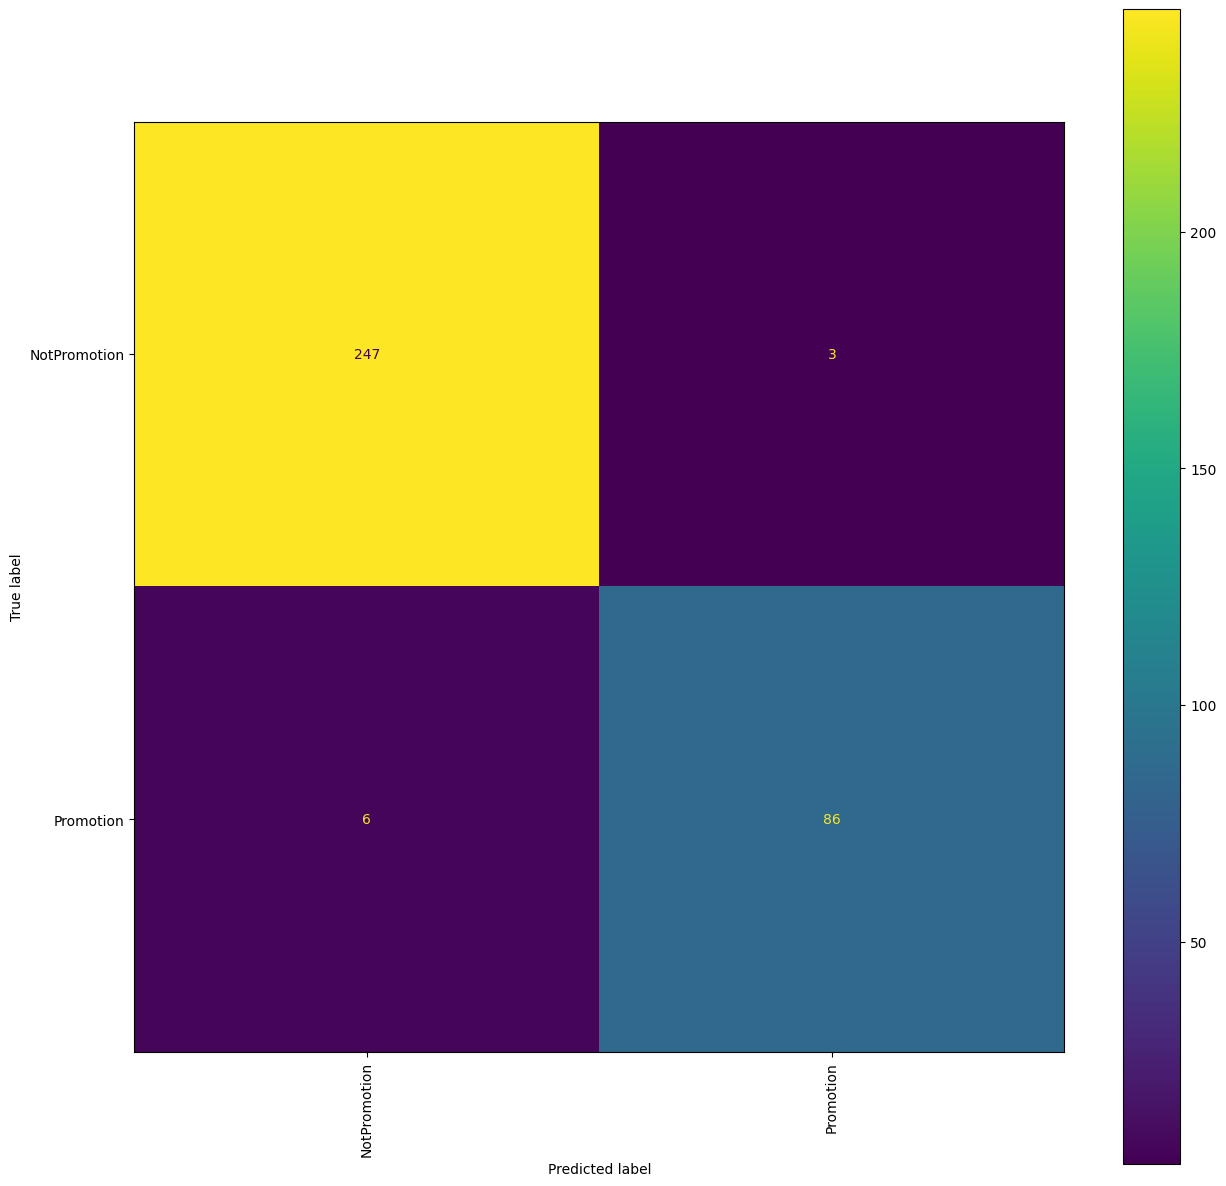

In [10]:
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = label_type)

fig, ax = plt.subplots(figsize=(15,15))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest model
rf_model = RandomForestClassifier()
rf_model.fit(X_resampled, y_resampled)

# Predict and evaluate
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_val, y_pred))

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       250
           1       0.98      0.87      0.92        93

    accuracy                           0.96       343
   macro avg       0.96      0.93      0.95       343
weighted avg       0.96      0.96      0.96       343

Accuracy: 0.9592
Precision: 0.9759
Recall: 0.8710
F1-score: 0.9205


In [12]:
# Evaluate model performance
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred))

precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       250
           1       0.96      0.87      0.91        92

    accuracy                           0.96       342
   macro avg       0.96      0.93      0.94       342
weighted avg       0.96      0.96      0.96       342

Precision: 0.9564
Recall: 0.9561
F1-score: 0.9554


Confusion Matrix:



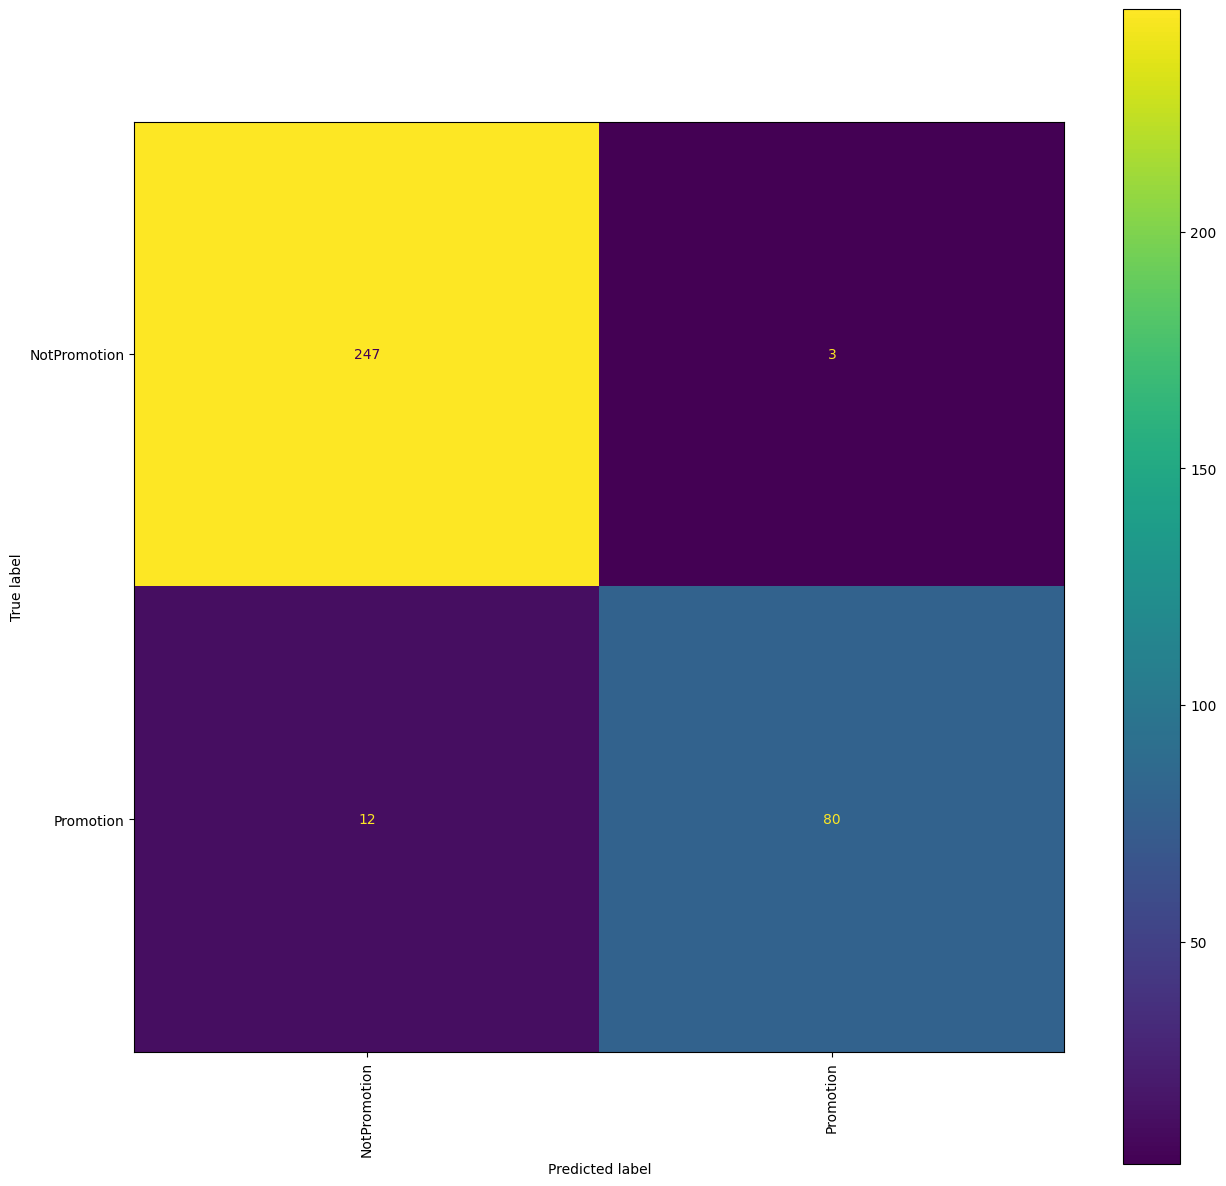

In [13]:
display = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred), display_labels = label_type)

fig, ax = plt.subplots(figsize=(15,15))
print(f"Confusion Matrix:\n")
display.plot(ax=ax, xticks_rotation='vertical')